In [1]:
from functools import partial
import time

import flows
import haiku as hk
import jax
from jax import random
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
from tqdm.auto import trange

from diffbank.metric import get_density as _get_density
from diffbank.noise import Sn_aLIGO
from diffbank.utils import get_m1_m2_sampler, gen_templates_rejection
from diffbank.waveforms.twoPN_simple import amp, Psi

from flow_utils import get_modules

Generate training data and fit flow

In [2]:
t_start = time.time()

In [3]:
key = random.PRNGKey(20)
m_range = (1.0, 3.0)
fs = jnp.linspace(20.0, 2000.0, 1000)
m1_m2_sampler = get_m1_m2_sampler(m_range, m_range)
get_density = jax.jit(lambda theta: _get_density(theta, amp, Psi, fs, Sn_aLIGO))
density_max = get_density(jnp.array([m_range[0], m_range[0]]))


@partial(jax.jit, static_argnums=(1,))
def sample_theta(key, n):
    return gen_templates_rejection(
        key, density_max, n, lambda _, theta: get_density(theta), m1_m2_sampler
    )


# Sample training set
key, subkey = random.split(key)
train_set = sample_theta(subkey, 5000)

# Sample validation set
key, subkey = random.split(key)
val_set = sample_theta(subkey, 1000)

In [4]:
# Definitions
modules = get_modules("realnvp", 5, True, 100)
bijection = flows.Serial(*modules)
prior = flows.Normal()
opt = optax.adam(3e-5)

# Initialize
init_fun = flows.Flow(bijection, prior)
key, subkey = random.split(key)
params, log_pdf, sample = init_fun(subkey, input_dim=2)
opt_state = opt.init(params)


@jax.jit
def loss(params, batch):
    """Negative log-likelihood"""
    return -log_pdf(params, batch).sum()


@jax.jit
def update(params, opt_state, batch):
    """Learning rule"""
    value, grads = jax.value_and_grad(loss)(params, batch)
    updates, opt_state = opt.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state, value


# Training loop
train_losses = []
val_losses = []
val_interval = 4
n_steps = 400
batch_size = 128

with trange(n_steps) as pbar:
    for i in pbar:
        # Validation step
        if i % val_interval == 0:
            val_loss = loss(params, val_set)
            val_losses.append(val_loss / len(val_set))
            pbar.set_description(f"val: {val_losses[-1]}")

        # Train
        key, subkey = random.split(key)
        batches = jnp.array_split(
            random.permutation(subkey, train_set), len(train_set) // batch_size
        )
        epoch_loss = 0.
        for batch in batches:
            params, opt_state, batch_loss = update(params, opt_state, batch)
            epoch_loss += batch_loss
        train_losses.append(epoch_loss / len(train_set))

  0%|          | 0/400 [00:00<?, ?it/s]

In [5]:
t_end = time.time()

In [6]:
print(f"Duration: {(t_end - t_start) / 60} min")

Duration: 2.0482354839642842 min


Plotting

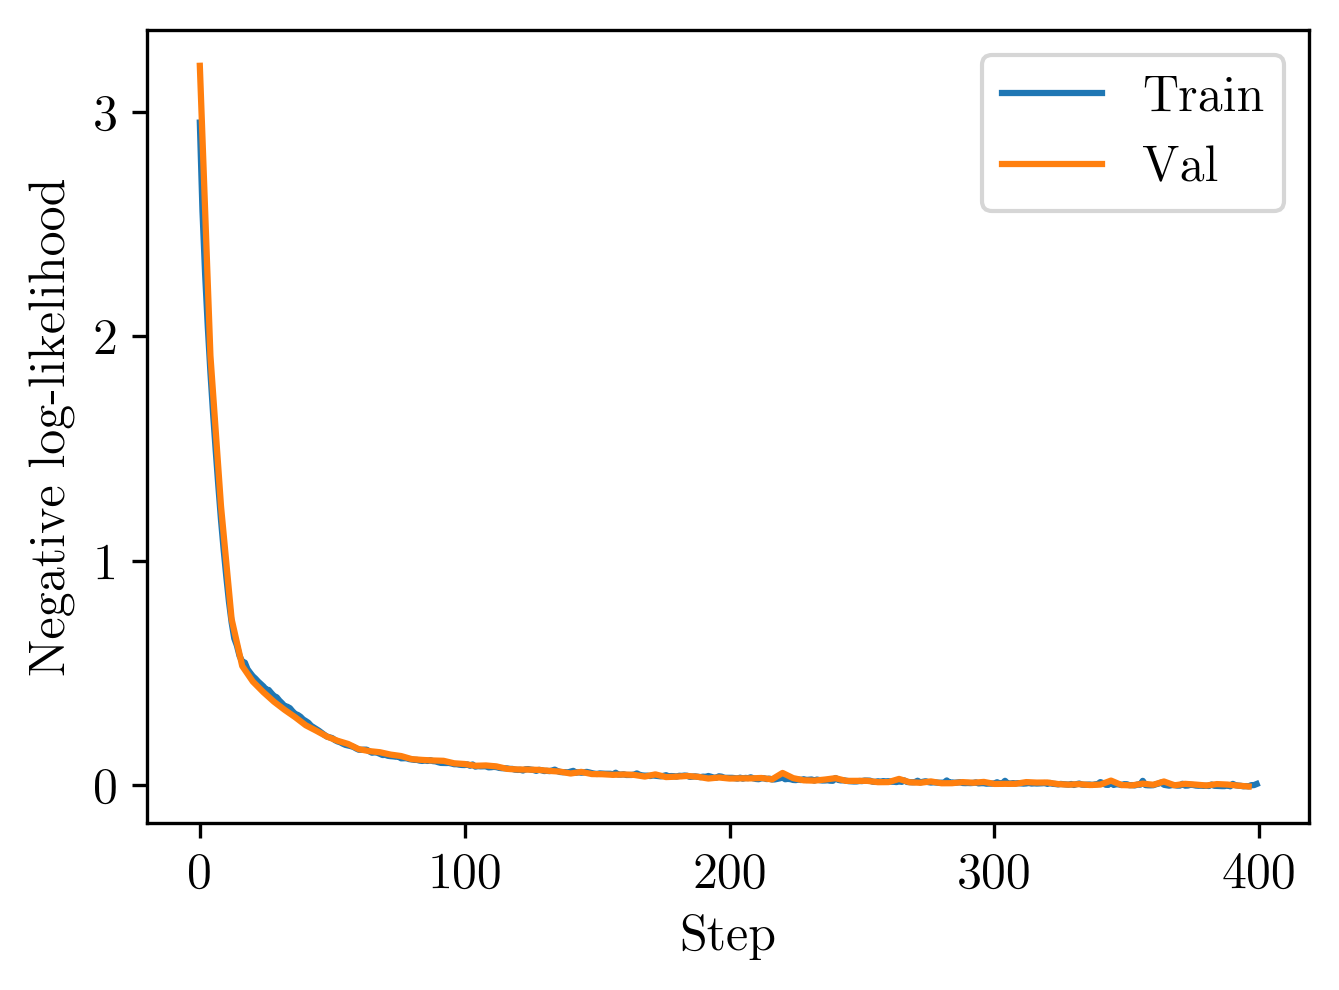

In [7]:
plt.plot(train_losses, label="Train")
plt.plot(jnp.arange(0, n_steps, val_interval), val_losses, label="Val")
plt.xlabel("Step")
plt.ylabel("Negative log-likelihood")
plt.legend()

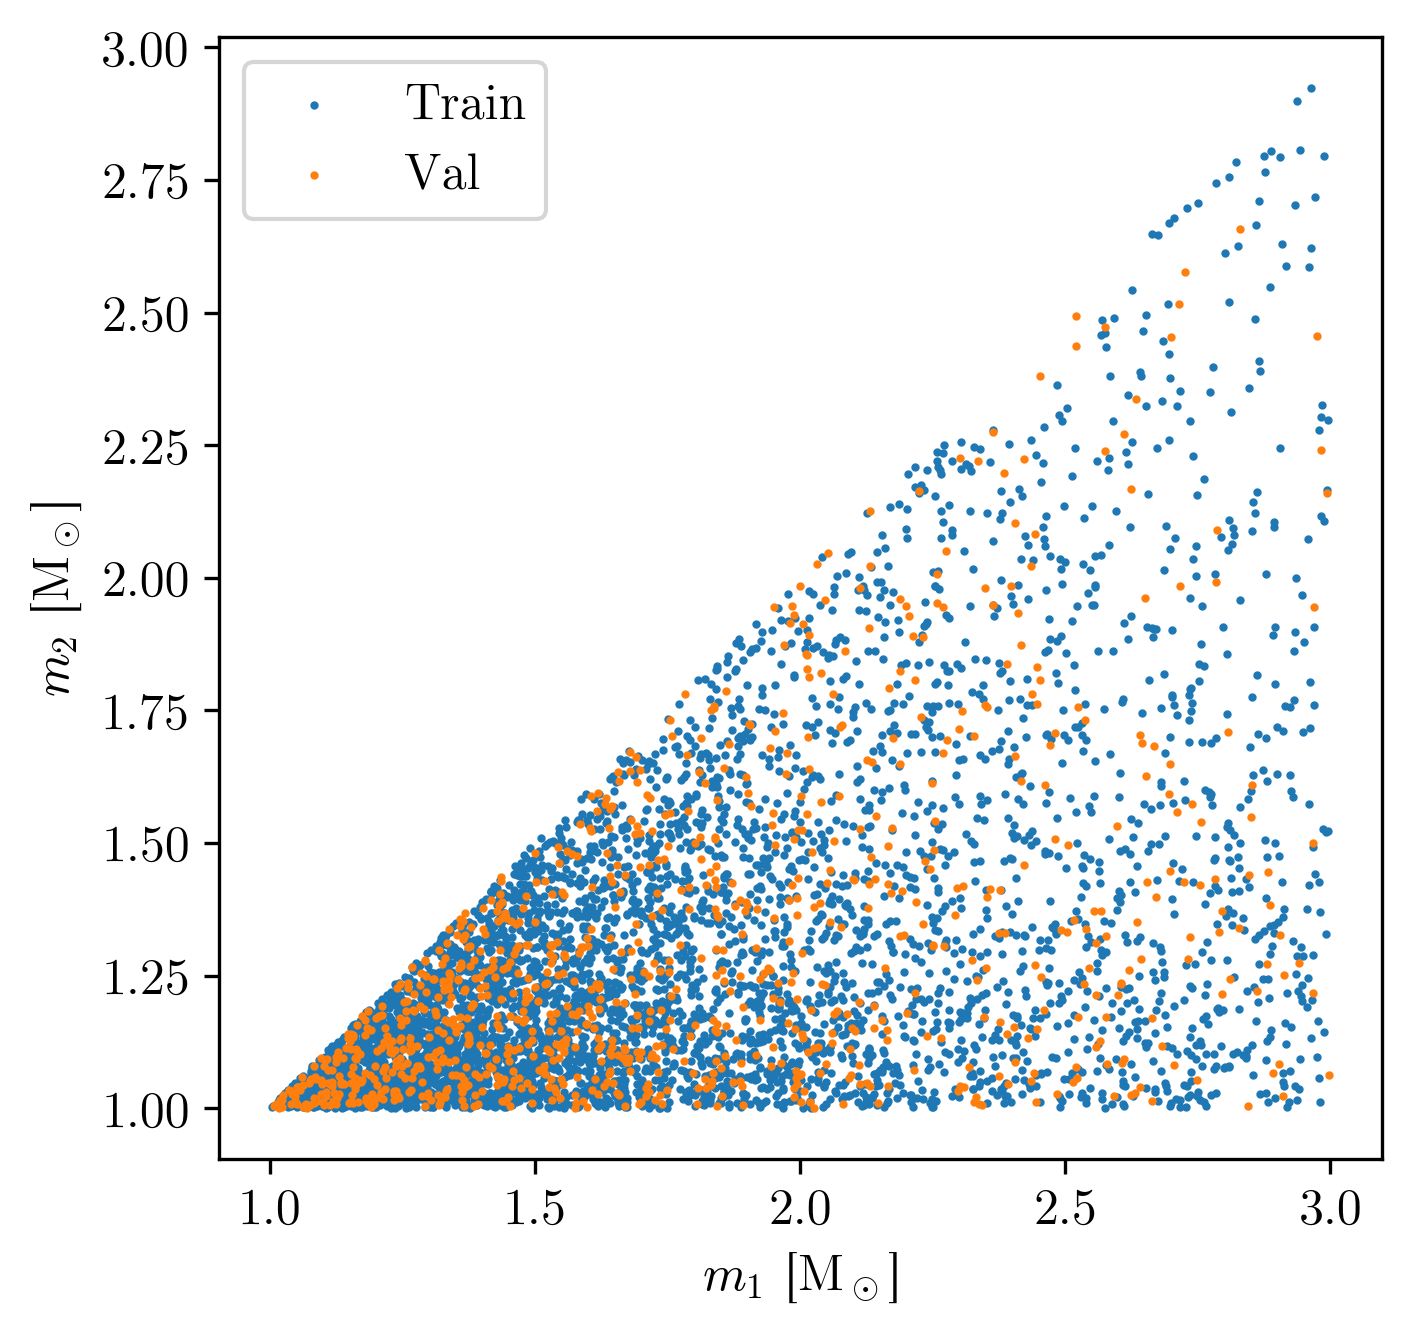

In [8]:
plt.figure(figsize=(5, 5))
plt.scatter(*train_set.T, s=1, label="Train")
plt.scatter(*val_set.T, s=1, label="Val")
plt.xlabel(r"$m_1$ [M$_\odot$]")
plt.ylabel(r"$m_2$ [M$_\odot$]")
plt.legend()
plt.gca().set_aspect("equal")

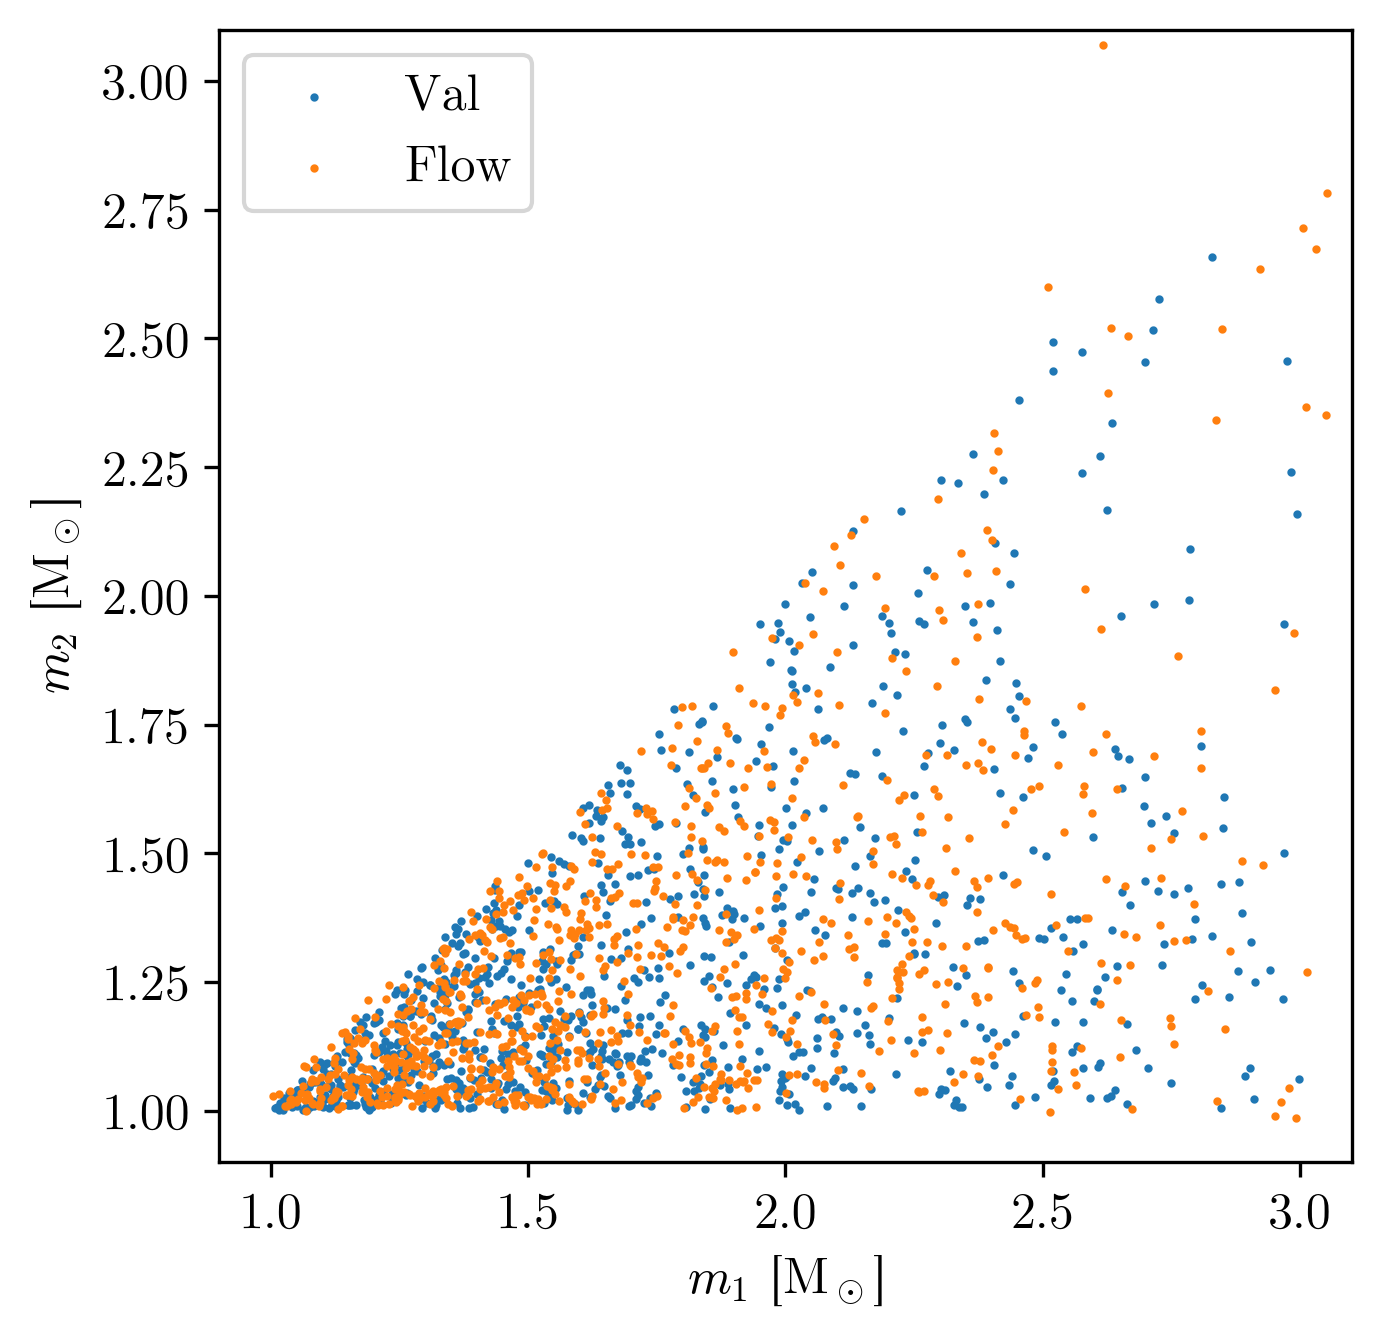

In [9]:
plt.figure(figsize=(5, 5))
# plt.scatter(*train_set.T, s=1, label="Train")
plt.scatter(*val_set.T, s=1, label="Val")

key, subkey = random.split(key)
plt.scatter(*sample(subkey, params, 1000).T, s=1, label="Flow")

plt.xlim(0.9, 3.1)
plt.ylim(0.9, 3.1)
plt.xlabel(r"$m_1$ [M$_\odot$]")
plt.ylabel(r"$m_2$ [M$_\odot$]")
plt.legend(loc="upper left")
plt.gca().set_aspect("equal")